### Preamble

In this notebook I attempt to develop a XGB Regressor model to predict the allocation of chlorophyll-a to 6 functional groups. These groups include diatoms (dia), chlorphytes (chl), cyanobacteria (cya), coccolithophores (coc), dinoflagellates (din), and phaeocystis (pha). Predictors available are; hyperspectral sea surface reflectance and environmental variables.

In [99]:
from pathlib import Path

import pandas as pd
from loguru import logger
from sklearn.model_selection import train_test_split

import mlflow
#import mlflow.xgboost
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np
from sklearn.utils import resample

import seaborn as sb
import matplotlib.pyplot as pp
import cmocean as co
import plotly.express as px
import shap


### Data Section

In [3]:
class DataLoader:
    def __init__(
            self, data_path, rrs_file='df_nwa_rrs.pqt',
            phy_file='df_nwa_phyto.pqt'):
        data_path = Path(data_path).resolve()
        preprocessed_data_path = data_path #/ '02_extracted/pcc_sims/subset'
        self.data_path = preprocessed_data_path
        self.X_name = rrs_file
        self.Y_name = phy_file
        logger.debug(f"Data directory set to {self.data_path.as_posix()}")
        logger.debug(f'Rrs file used: {self.X_name}')
        logger.debug(f'Phytoplankton file use {self.Y_name}')
   
    def load_data(self):
        """Loads and preprocesses data."""
        try:
            dX = pd.read_parquet(self.data_path / self.X_name, engine='pyarrow')
            dY = pd.read_parquet(self.data_path / self.Y_name, engine='pyarrow')

            # Data preprocessing (handle missing values, type conversion, etc.)
            dX = dX.astype(float) 
            dY = dY.astype(float) 

            return dX, dY

        except FileNotFoundError:
            logger.error(f"Error: Files not found in directory {self.data_path}")
            return None, None  # Return None on error
        except pd.errors.EmptyDataError:
            logger.error(f"Error: Empty data files in directory {self.data_path}")
            return None, None
        except Exception as e:  # Catch other potential exceptions
            logger.error(f"Error loading data: {e}")
            return None, None 
        

In [4]:
data_path = Path.home() / 'data/craig_pfc_2023/step_2_cleaned'
project_path = Path.cwd().parent

assert data_path.exists()
assert project_path.exists()

In [5]:
[i for i in data_path.glob('*.pqt')]

[PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_phy.pqt'),
 PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_rrs.pqt'),
 PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_env.pqt'),
 PosixPath('/Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned/df_all.pqt')]

#### Loading phyto and rrs data

In [6]:
loader = DataLoader(data_path=data_path, rrs_file = 'df_rrs.pqt', phy_file='df_phy.pqt')

2025-03-08 11:55:53.119 | DEBUG    | __main__:__init__:10 - Data directory set to /Users/erdemkarakoylu/data/craig_pfc_2023/step_2_cleaned
2025-03-08 11:55:53.120 | DEBUG    | __main__:__init__:11 - Rrs file used: df_rrs.pqt
2025-03-08 11:55:53.120 | DEBUG    | __main__:__init__:12 - Phytoplankton file use df_phy.pqt


In [7]:
dX, dY =  loader.load_data()

In [8]:
def compute_plot_corr_matrix(dfcorr, i_start=0, i_end=150, vmin=0, vmax=1):
# Generate a mask for the upper triangle

    mask = np.triu(np.ones_like(dfcorr, dtype=bool))
    _, ax = pp.subplots(figsize=(8, 6))
    sb.heatmap(dfcorr, vmin=vmin, vmax=vmax, ax=ax, mask=mask)
    return ax

<Axes: >

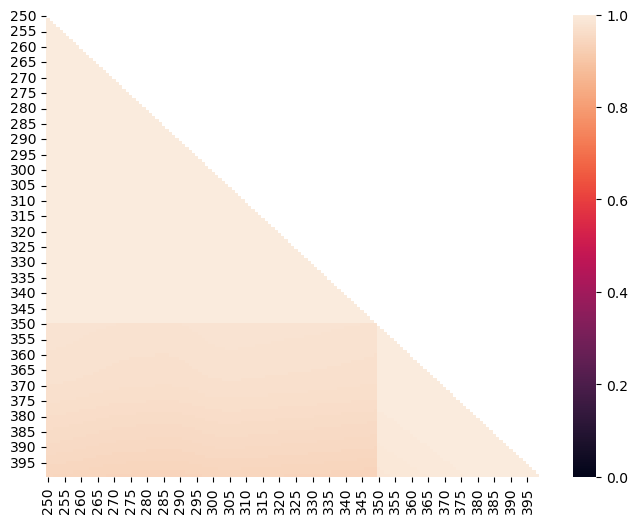

In [9]:
col_i_start, col_i_end = 0, 150
d_corr = dX.iloc[:, col_i_start:col_i_end].corr(method='spearman')
compute_plot_corr_matrix(d_corr)

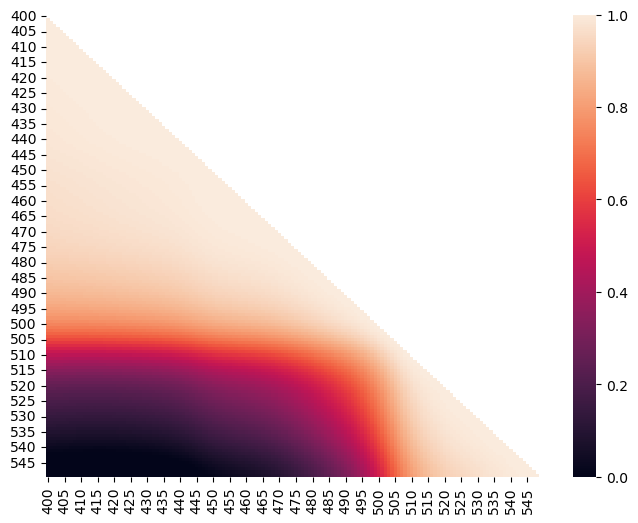

In [10]:
col_i_start, col_i_end = 150, 300
d_corr = dX.iloc[:, col_i_start:col_i_end].corr(method='spearman')
ax = compute_plot_corr_matrix(d_corr)

In [11]:
col_i_start, col_i_end = 200, 450
d_corr = dX.iloc[:, col_i_start:col_i_end].corr(method='spearman')


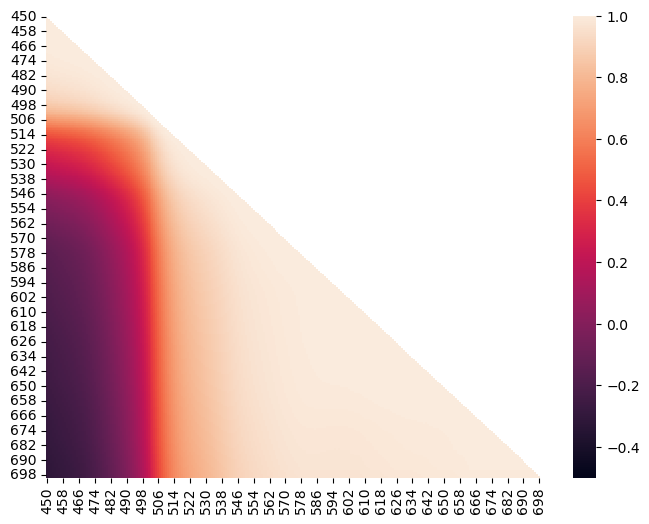

In [12]:
ax = compute_plot_corr_matrix(d_corr, vmin=-0.5, vmax=1)

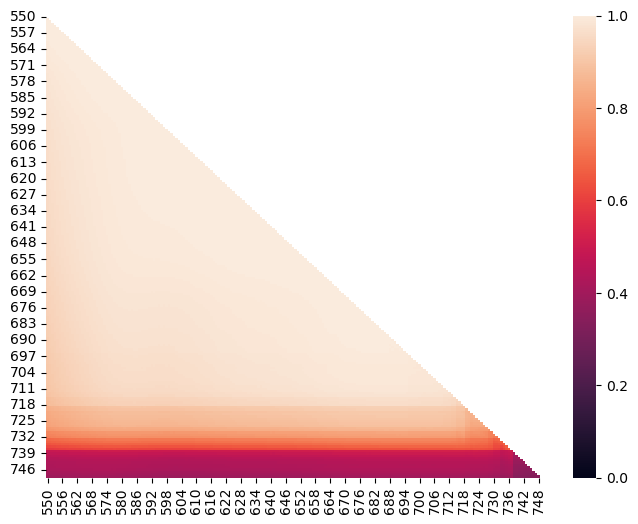

In [13]:
col_i_start, col_i_end = 300, 500
d_corr = dX.iloc[:, col_i_start:col_i_end].corr(method='spearman')


ax = compute_plot_corr_matrix(d_corr, vmin=0)

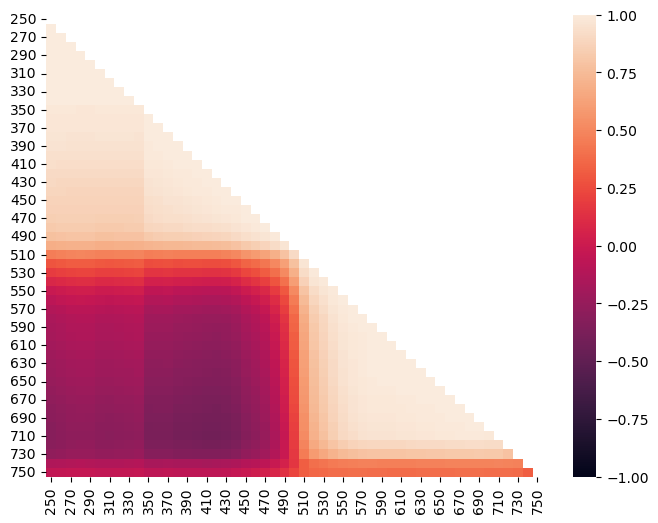

In [14]:
#col_i_start, col_i_end = 300, 500
d_corr = dX.iloc[:, ::10].corr(method='spearman')


ax = compute_plot_corr_matrix(d_corr, vmin=-1)

In [15]:
dX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1261607 entries, 9 to 2089135
Columns: 501 entries, 250 to 750
dtypes: float64(501)
memory usage: 4.7 GB


In [16]:
dY.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1261607 entries, 9 to 2089135
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   dia        1261607 non-null  float64
 1   chl        1261607 non-null  float64
 2   cya        1261607 non-null  float64
 3   coc        1261607 non-null  float64
 4   din        1261607 non-null  float64
 5   pha        1261607 non-null  float64
 6   tot_cphyl  1261607 non-null  float64
dtypes: float64(7)
memory usage: 77.0 MB


In [17]:
dX_train, dX_test, dY_train, dY_test = train_test_split(
    dX, dY
)

In [18]:
dX_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946205 entries, 2088599 to 76798
Columns: 501 entries, 250 to 750
dtypes: float64(501)
memory usage: 3.5 GB


In [19]:
dX_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315402 entries, 1446919 to 791894
Columns: 501 entries, 250 to 750
dtypes: float64(501)
memory usage: 1.2 GB


#### Scaling the target data:

<u>Why?</u>

Consistent Learning:
<br>$\rightarrow$ When multiple targets have drastically different scales, the model might implicitly focus more on learning patterns in the targets with larger magnitudes. <br>$\rightarrow$ Standardization can help bring all targets to a similar scale, potentially improving learning across all outputs.

In [20]:
scl = StandardScaler()

In [21]:
dY_train_s = pd.DataFrame(scl.fit_transform(dY_train), columns=dY_train.columns)
dY_test_s = pd.DataFrame(scl.transform(dY_test), columns=dY_test.columns)

In [22]:
dY_train_s.describe()

,dia,chl,cya,coc,din,pha,tot_cphyl
count,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05,9.462050e+05
mean,-6.219281e-17,1.673394e-16,1.830791e-16,1.215020e-16,1.126409e-17,1.028787e-17,-1.379626e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.537926e-01,-4.649406e-01,-7.460713e-01,-4.565006e-01,-8.754418e-02,-2.846996e-01,-6.546203e-01
25%,-5.520880e-01,-4.649406e-01,-7.460713e-01,-4.560229e-01,-8.754418e-02,-2.846996e-01,-4.325646e-01
50%,-5.140659e-01,-4.629903e-01,-6.448702e-01,-4.050141e-01,-8.754418e-02,-2.846996e-01,-2.358163e-01
75%,1.074932e-01,-8.333009e-02,5.906282e-01,-6.979211e-02,-8.754415e-02,-2.830429e-01,1.275014e-01
max,1.377459e+01,2.234591e+01,1.657667e+01,1.724679e+01,1.049352e+02,2.780865e+01,2.848294e+01


### Modeling Section

#### 1. Predict

In [23]:
class XGBoostTrainer:
    def __init__(self, params):
        self.params = params

    def train_model(self, X_train, y_train):
        """Trains the XGBoost model."""
        with mlflow.start_run():
            model = MultiOutputRegressor(xgb.XGBRegressor(**self.params))
            model.fit(X_train, y_train)
            return model
        
    def predict_with_uncertainty(
            self, model, X_new, num_bootstrap_samples=100, return_all_predictions=False):
        """
        Predicts target values with uncertainty estimation using bootstrapping.
        """

        all_predictions = np.zeros(
            (
                num_bootstrap_samples, X_new.shape[0], 
                len(self.params["objective"])
                )
            )
        for i in range(num_bootstrap_samples):
            X_resampled, y_resampled = resample(self.X_train, self.y_train)
            model.fit(X_resampled, y_resampled)
            all_predictions[i] = model.predict(X_new)
        
        if return_all_predictions:
            return all_predictions
        # Calculate statistics across bootstrap samples
        mean_predictions = np.mean(all_predictions, axis=0)
        std_dev_predictions = np.std(all_predictions, axis=0)
        return mean_predictions, std_dev_predictions


In [24]:
params = {
    "objective": "reg:squarederror",  # Basic parameter
    "n_estimators": 50,                # Small number for faster testing
    "seed": 42                        # For reproducibility
    }
trainer = XGBoostTrainer(params=params)
xgbmodel = trainer.train_model(dX_train, dY_train_s)

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

In [25]:
xgbmodel

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

### Model Evaluation

In [26]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error)

In [27]:
print(f'{dX_test.size:,}')
print(f'{dX_test.shape[0]:,}')

158,016,402
315,402


In [28]:
Y_pred_s = xgbmodel.predict(dX_test)

In [29]:
Y_pred = scl.inverse_transform(Y_pred_s)

In [30]:
dY_pred = pd.DataFrame(
    Y_pred, columns=dY_test.columns
    )

In [31]:
dY_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315402 entries, 1446919 to 791894
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   dia        315402 non-null  float64
 1   chl        315402 non-null  float64
 2   cya        315402 non-null  float64
 3   coc        315402 non-null  float64
 4   din        315402 non-null  float64
 5   pha        315402 non-null  float64
 6   tot_cphyl  315402 non-null  float64
dtypes: float64(7)
memory usage: 19.3 MB


In [32]:
dY_test.describe()

,dia,chl,cya,coc,din,pha,tot_cphyl
count,315402.000000,3.154020e+05,3.154020e+05,315402.000000,3.154020e+05,3.154020e+05,3.154020e+05
mean,0.070165,2.271858e-02,1.918694e-02,0.033773,6.253313e-04,1.199798e-01,2.664484e-01
std,0.126860,4.895396e-02,2.576892e-02,0.074217,7.025775e-03,4.206500e-01,4.056590e-01
min,0.000000,0.000000e+00,2.294837e-33,0.000000,2.592176e-33,6.308696e-37,3.206452e-13
25%,0.000215,8.108957e-14,2.315888e-13,0.000035,4.453605e-23,1.560142e-32,9.051844e-02
50%,0.004992,9.688802e-05,2.573092e-03,0.003852,2.643666e-17,4.222489e-19,1.706562e-01
75%,0.083889,1.864117e-02,3.436198e-02,0.028668,1.617136e-10,7.599147e-04,3.178496e-01
max,1.497105,1.046813e+00,4.471208e-01,1.650084,7.721317e-01,1.074724e+01,1.074724e+01


In [33]:
dY_test.to_csv('~/Desktop/dy_test.csv')

In [34]:
def model_eval (dY_true, dY_pred):
    scores_dict = dict()
    for col in dY_true.columns:  # Iterate over each output column
        mse = mean_squared_error(
            dY_true[col], dY_pred[col])  
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(
            dY_true[col], dY_pred[col])
        r2 = r2_score(
            dY_true[col], dY_pred[col])
        mape = mean_absolute_percentage_error(
           dY_true[col], dY_pred[col] 
        )
        mae_to_dev_ratio = mae / dY_true[col].std()
        logger.info(f"\nMetrics for {col}:")
        logger.info(f"  MSE: {mse:.4f}")
        logger.info(f"  RMSE: {rmse:.4f}")
        logger.info(f"  MAE: {mae:.4f}")
        logger.info(f"  R-squared: {r2:.4f}")
        logger.info(f"  MAE/StDev_true {mae_to_dev_ratio:.3f}")
        scores_dict[col] = dict(mse=mse, rmse=rmse, mae=mae, r2=r2, mape=mape, mae_2_true_std_ratio=mae_to_dev_ratio)
    return scores_dict

Good results for 
* Tot CHL
* Dia
* Cya

### Understanding the results

In [35]:
def plot_regression(true, predicted, name, ax=None, leg=None):
    if ax is None:
        f, ax = pp.subplots()
    ax.scatter(true, predicted, color='k')
    max_xy = max(true.max(), predicted.max())
    ax.plot((0, max_xy), (0, max_xy), ls='--', color='r')
    ax.text(max_xy/10, max_xy*.8, leg, fontdict=dict(fontsize=13, color='blue'))
    ss = ax.get_subplotspec()
    if ss.is_first_col():
        ax.set_ylabel('pred.')
    else:
        ax.set_ylabel("")
    if  ss.is_last_row():    
        ax.set_xlabel('true')
    else:
        ax.set_xlabel("")
    ax.set_title(name)
    ax.set_aspect('equal')

In [ ]:
def plot_residuals(y_true, y_pred, ax, data_name):
    """Plots residuals for model-predicted targets."""
    errors = y_pred - y_true
    ss = ax.get_subplotspec()
    ax.scatter(y_pred, errors)
    if ss.is_first_row():
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Predicted values')
    if ss.is_first_col():
        ax.set_ylabel('Residuals')
    else:
        ax.set_ylabel("")
    ax.set_title(f"Residual Plot for {data_name}")
    ax.axhline(y=0, color='r', linestyle='--')

In [83]:
def compute_shapley_values(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    return shap_values

def get_main_features(shap_vals,  X):
    # Get the displayed feature names
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    feature_order = np.argsort(mean_abs_shap)[::-1] #Sort by importance, descending
    displayed_feature_names = X.columns[feature_order].tolist()
    return displayed_feature_names

def plot_shap(shap_values, X, target_name:str, input_types: str='rrs'):
    shap.summary_plot(shap_values, X, plot_type='layered_violin', color='coolwarm', show=False)
    pp.savefig(f'shap_{input_types}_{target_name}.pdf', dpi=300)
    pp.savefig(f'shap_{input_types}_{target_name}.png', dpi=300)


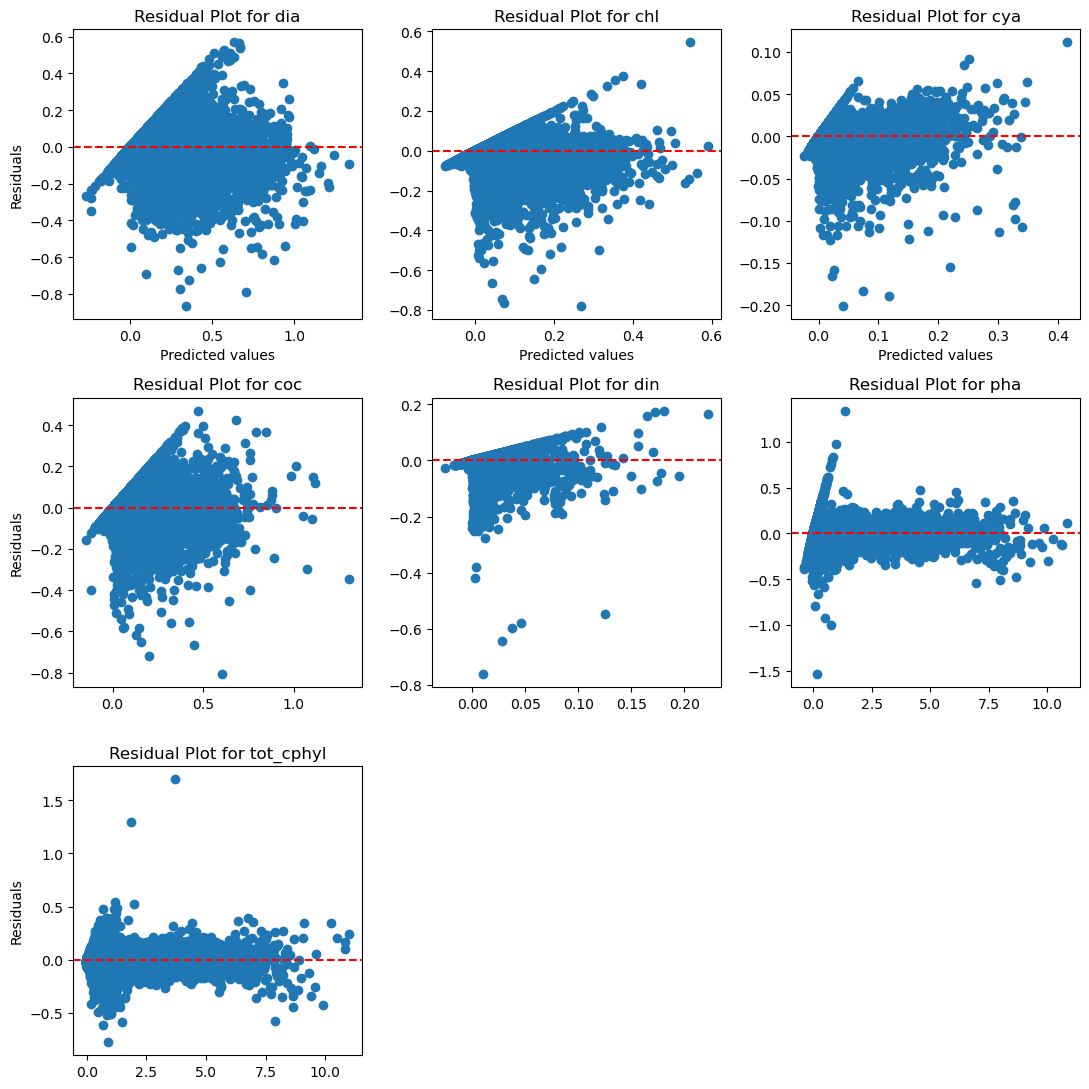

In [38]:
f, axs = pp.subplots(nrows=3, ncols=3, figsize=(11, 11))
for ax, col in zip(axs.ravel(), dY_test.columns):
    try:
        plot_residuals(dY_test[col].values, dY_pred[col].values, ax, col)
    except:
        logger.error(f"problem with {col}")
axs.ravel()[-2].set_visible(False)
axs.ravel()[-1].set_visible(False)
f.tight_layout()   

When a residual plot has a few points lined up as though hitting a wall, with no points beyond that wall, it suggests that there might be a boundary or constraint in the data that is not being accounted for by the regression model. This pattern can indicate several potential issues:
* Boundary Constraints: The dependent variable might have a natural limit or boundary that is not being captured by the model. For example, if the dependent variable is a percentage, it cannot exceed 100% or go below 0%.
* Censoring or Truncation: The data might be censored or truncated, meaning that values beyond a certain threshold are not observed or are recorded differently.
* Model Misspecification: The model might be missing important variables or higher-order terms that could explain the non-linear pattern or the boundary effect.
* Outliers or Influential Points: The points hitting the wall might be outliers or influential points that are affecting the regression line, causing the residuals to exhibit this pattern.

XGBoost supports multi-output regression starting from version 1.6, with experimental support and limited features primarily tested in the Python package.
 However, if you encounter issues with the residual plot, such as a clear pattern or boundary issues, it might indicate problems with the model's performance or the data itself.

Common Issues and Solutions
1. Pattern in Residuals:
Decreasing Pattern: If there is a clear decreasing pattern in the residual plot, it suggests that the model is not capturing some aspects of the data well. This could be due to underfitting or overfitting.
Solution: Try adjusting the model's hyperparameters, such as max_depth, learning_rate, and n_estimators. You can also consider adding more features or transforming existing ones to better capture the underlying patterns in the data.
2. Boundary Issues:
Outliers or Non-Linear Relationships: If the residuals show boundary issues, it might indicate the presence of outliers or non-linear relationships that the model is not handling well.
Solution: Examine the data for outliers and consider using techniques like winsorization or log transformations to handle them. Additionally, you can try using non-linear models or adding interaction terms to capture complex relationships.

3. Data Preprocessing:
Normalization and Scaling: Ensure that the input features are normalized or scaled appropriately. This can help the model converge better and improve the residual plot.
Feature Engineering: Consider creating new features that might help the model capture the underlying patterns more effectively.
4. Evaluation and Diagnostics:
Cross-Validation: Use cross-validation to ensure that the model's performance is consistent across different subsets of the data.
Residual Analysis: Perform a thorough residual analysis to identify any systematic patterns or issues. This can help you diagnose and address specific problems.

In [39]:
eval_scores = model_eval(dY_test, dY_pred)

2025-03-08 12:13:02.134 | INFO     | __main__:model_eval:15 - 
Metrics for dia:
2025-03-08 12:13:02.134 | INFO     | __main__:model_eval:16 -   MSE: 0.0022
2025-03-08 12:13:02.135 | INFO     | __main__:model_eval:17 -   RMSE: 0.0468
2025-03-08 12:13:02.135 | INFO     | __main__:model_eval:18 -   MAE: 0.0280
2025-03-08 12:13:02.135 | INFO     | __main__:model_eval:19 -   R-squared: 0.8637
2025-03-08 12:13:02.135 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.221
2025-03-08 12:13:02.143 | INFO     | __main__:model_eval:15 - 
Metrics for chl:
2025-03-08 12:13:02.144 | INFO     | __main__:model_eval:16 -   MSE: 0.0006
2025-03-08 12:13:02.144 | INFO     | __main__:model_eval:17 -   RMSE: 0.0242
2025-03-08 12:13:02.144 | INFO     | __main__:model_eval:18 -   MAE: 0.0134
2025-03-08 12:13:02.144 | INFO     | __main__:model_eval:19 -   R-squared: 0.7548
2025-03-08 12:13:02.145 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.274
2025-03-08 12:13:02.151 | INFO     | __main__:mo

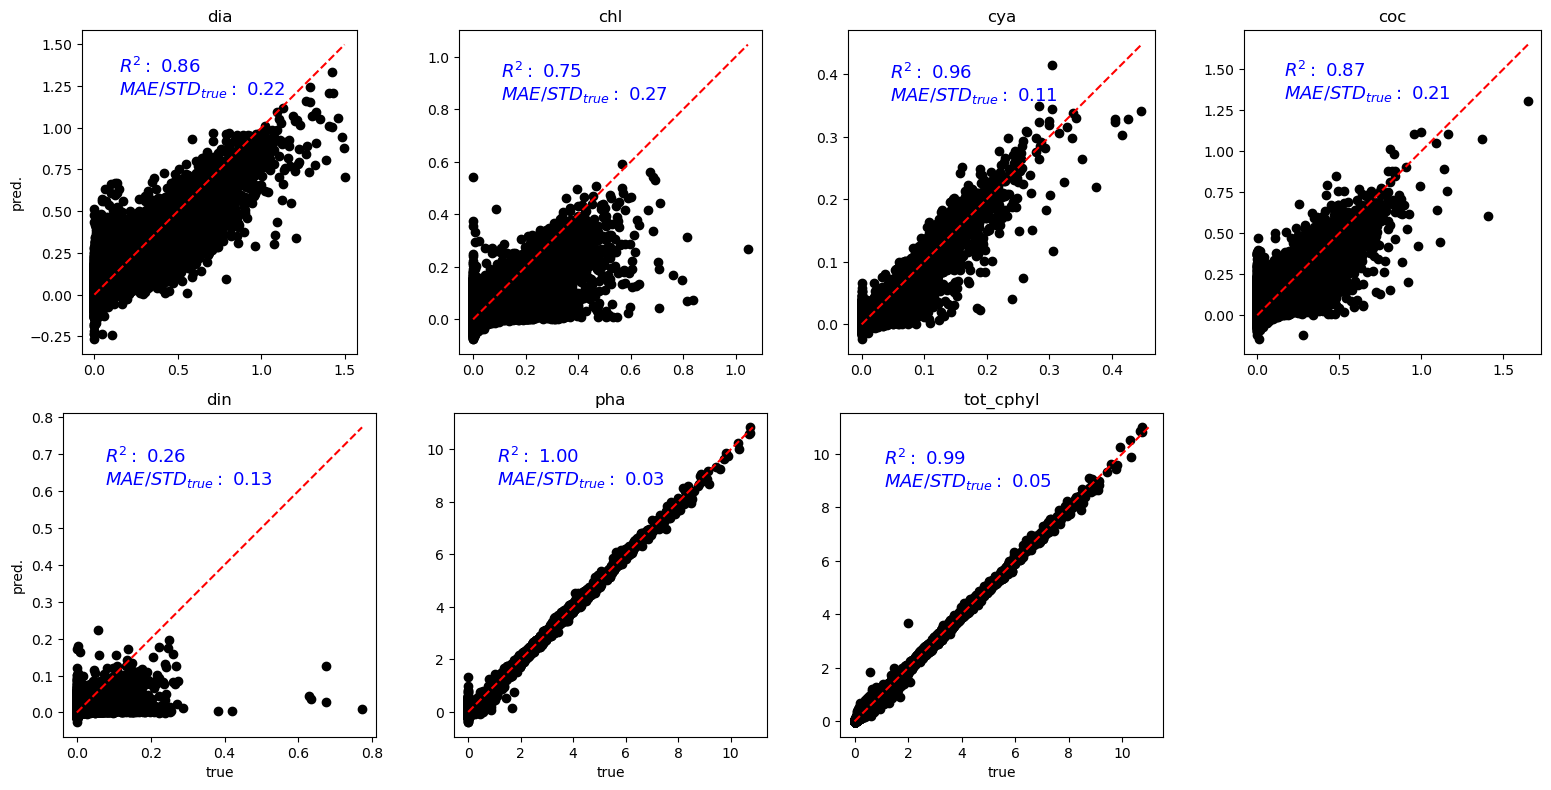

In [40]:
f, axs = pp.subplots(nrows=2, ncols=4, figsize=(16, 8))
for col, ax in zip(dY_test.columns, axs.ravel()):
    r2 = eval_scores[col]['r2']
    mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
    string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
    plot_regression(dY_test[col], dY_pred[col], col, ax=ax, leg=string)
for ax in axs.ravel()[-1:]:
    ax.set_visible(False)
f.tight_layout()

In [41]:
f.savefig('true_v_pred_rrs.pdf', dpi=300)
f.savefig('true_v_pred_rrs.png', dpi=300)

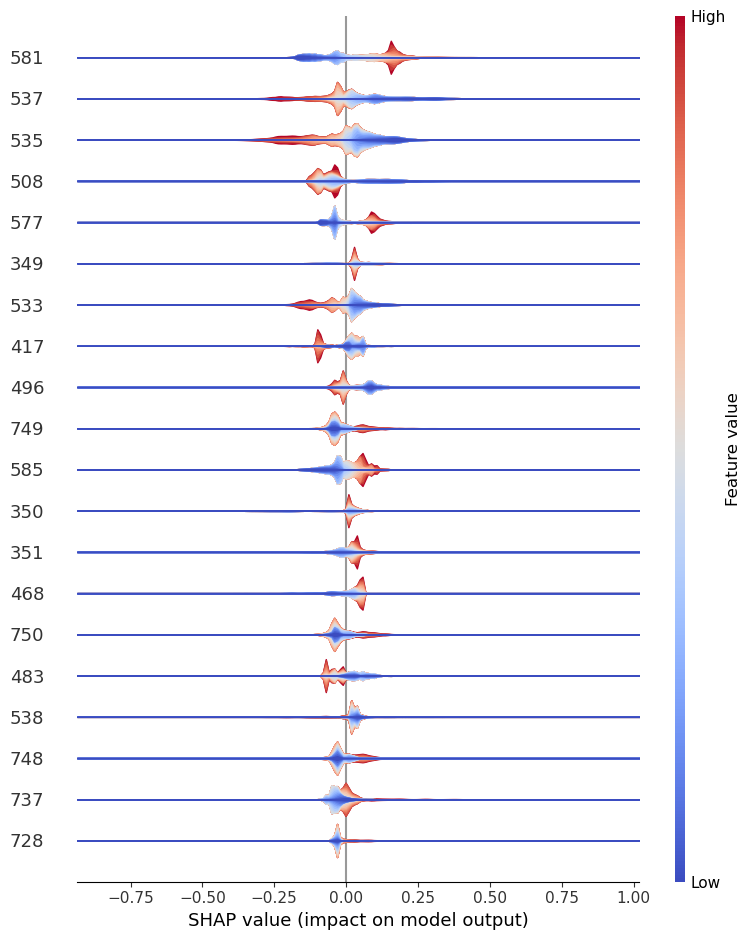

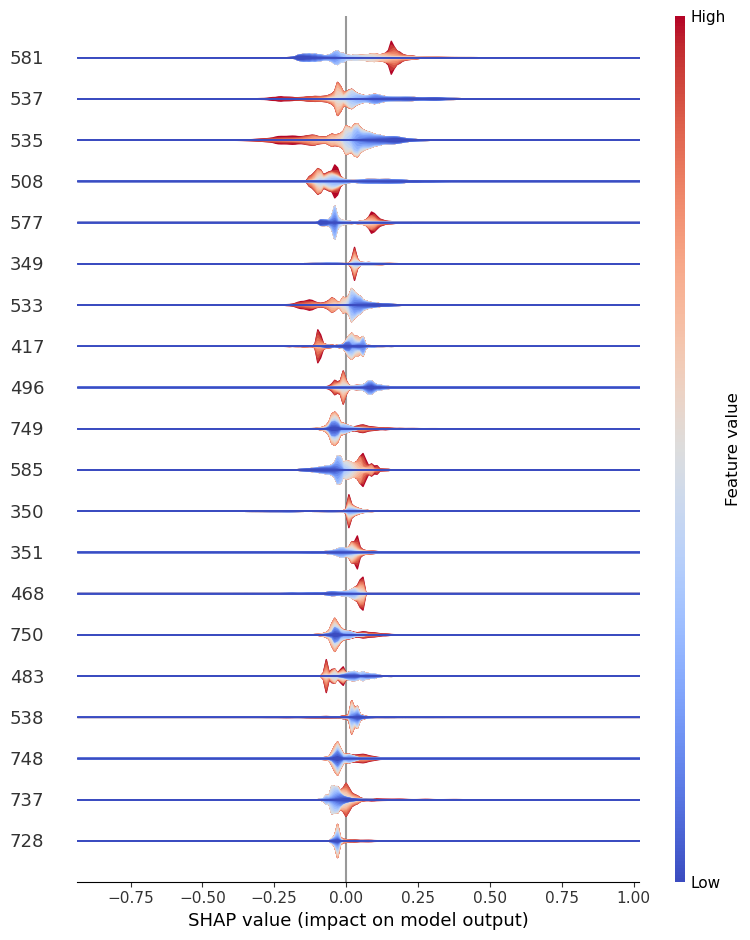

In [ ]:
# dia

model_nums = {k:i for i, k in enumerate(dY_test.columns)}
target = 'dia'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
main_features_dia = get_main_features(shap_vals, dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs')

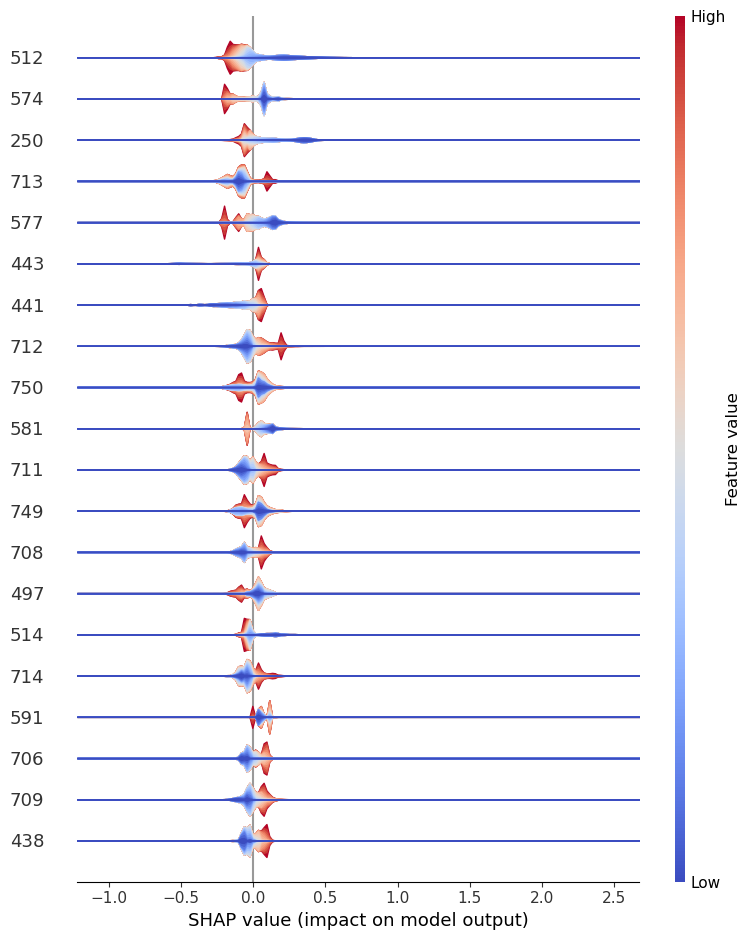

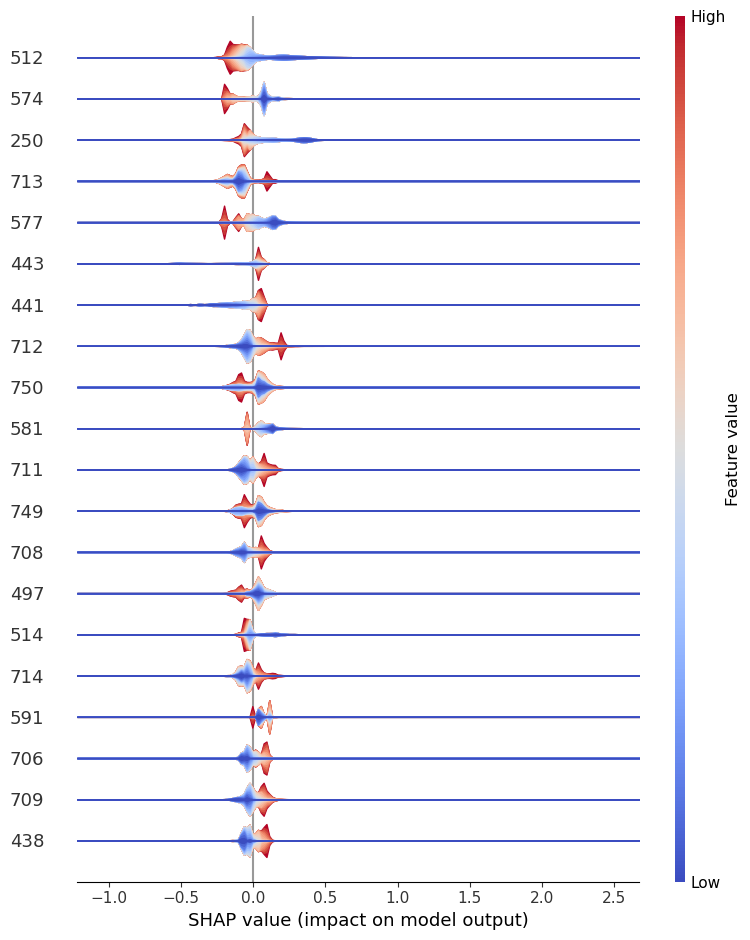

In [54]:
#chl
target = 'chl'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs')

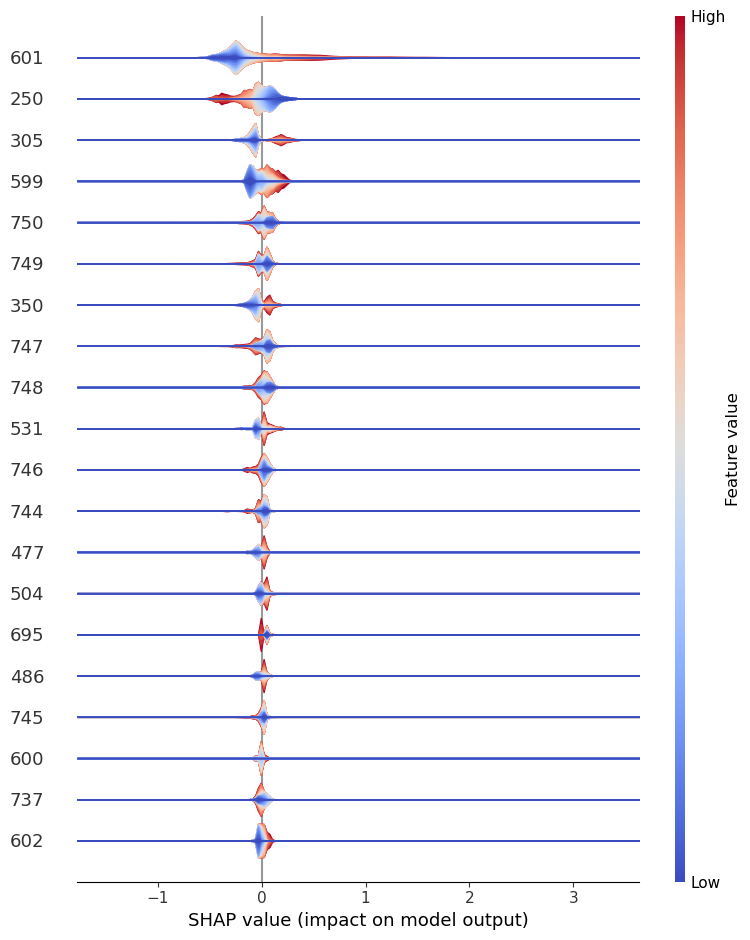

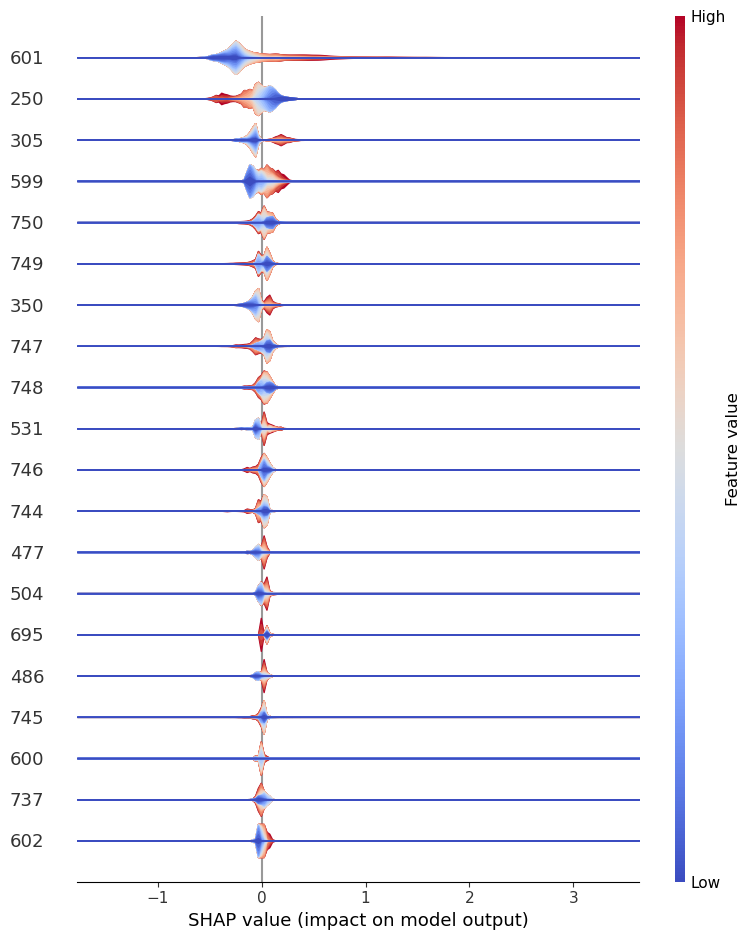

In [55]:
target = 'cya'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs')

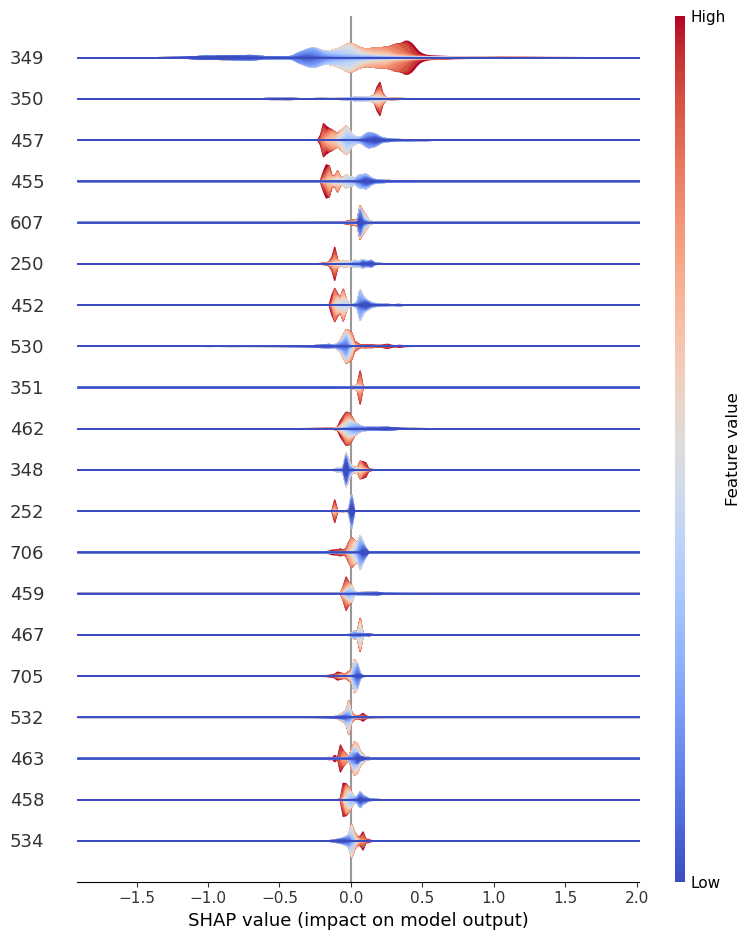

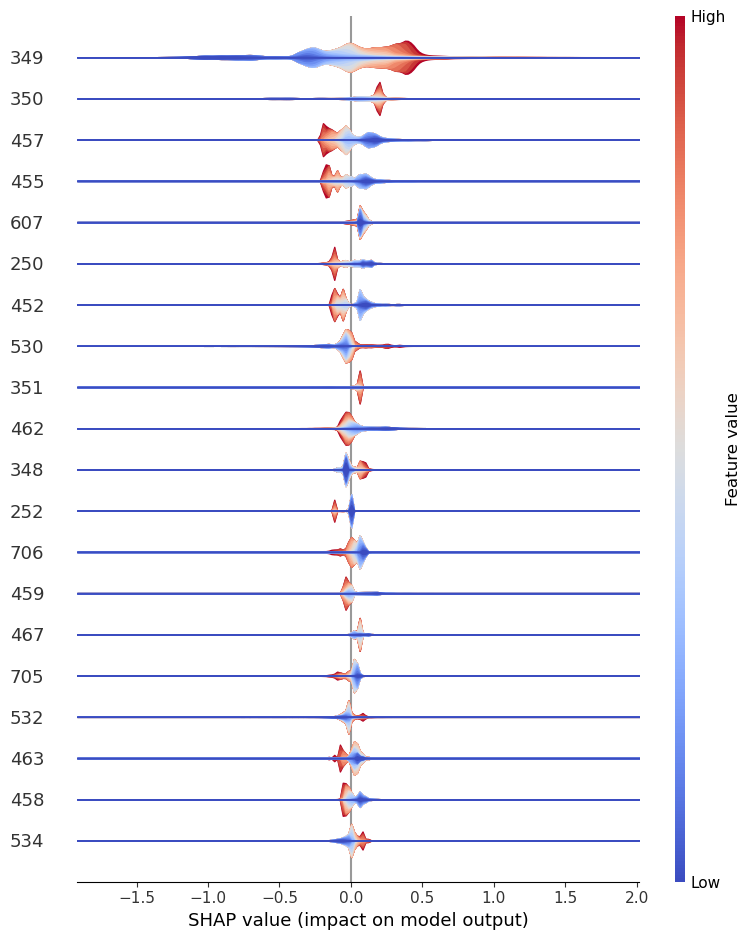

In [56]:

target = 'coc'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs')

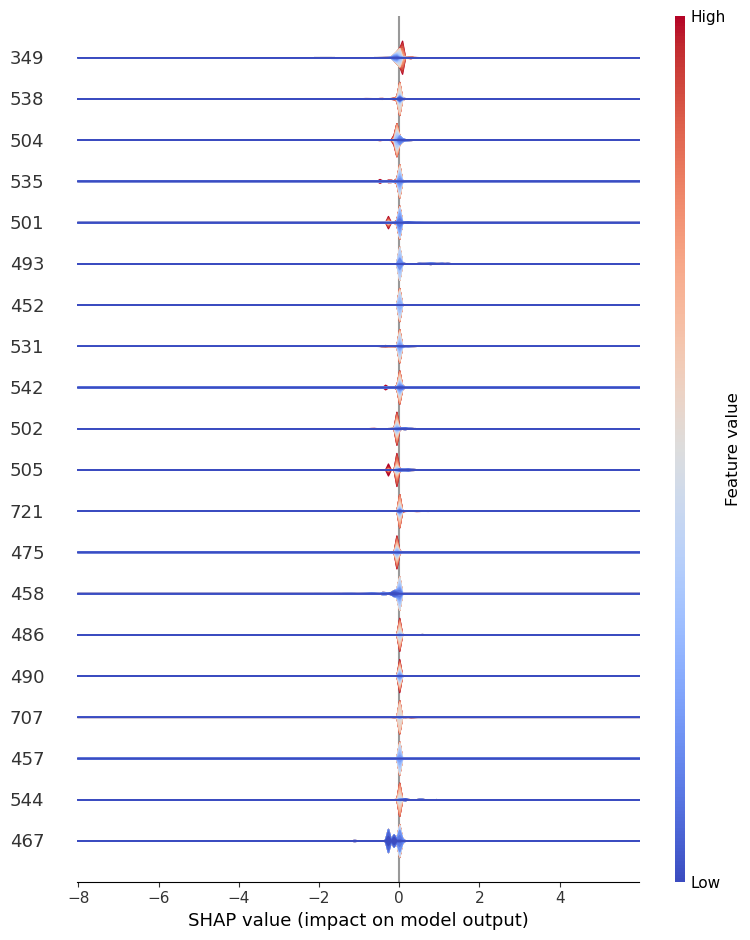

<Figure size 640x480 with 0 Axes>

In [46]:
target = 'din'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
plot_shap(model=model, X=dX_test, target_name=target, input_types='rrs')

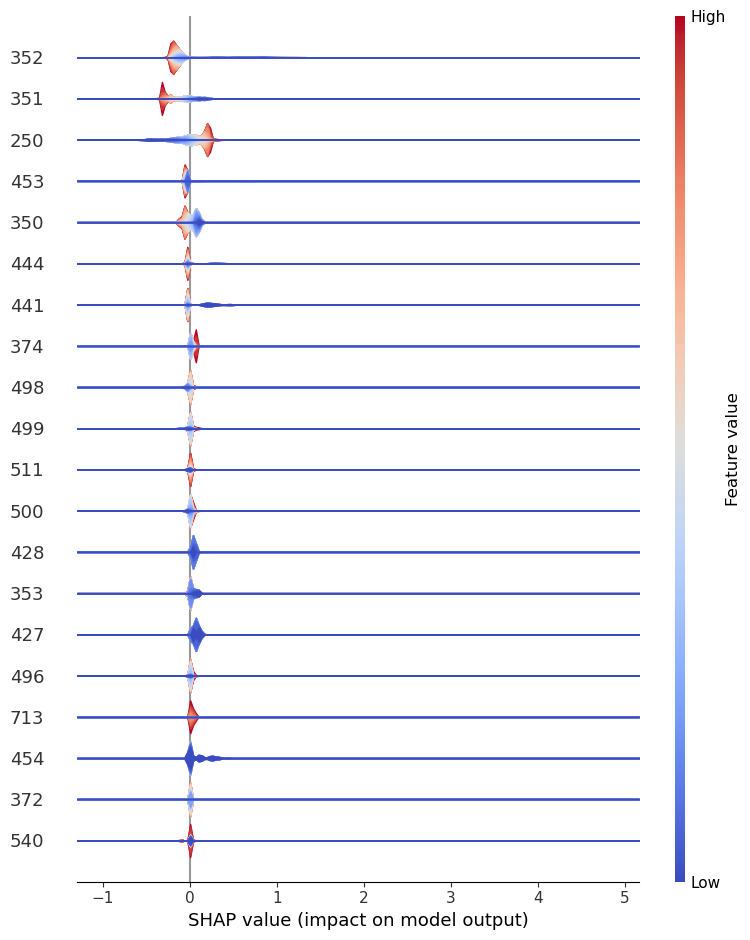

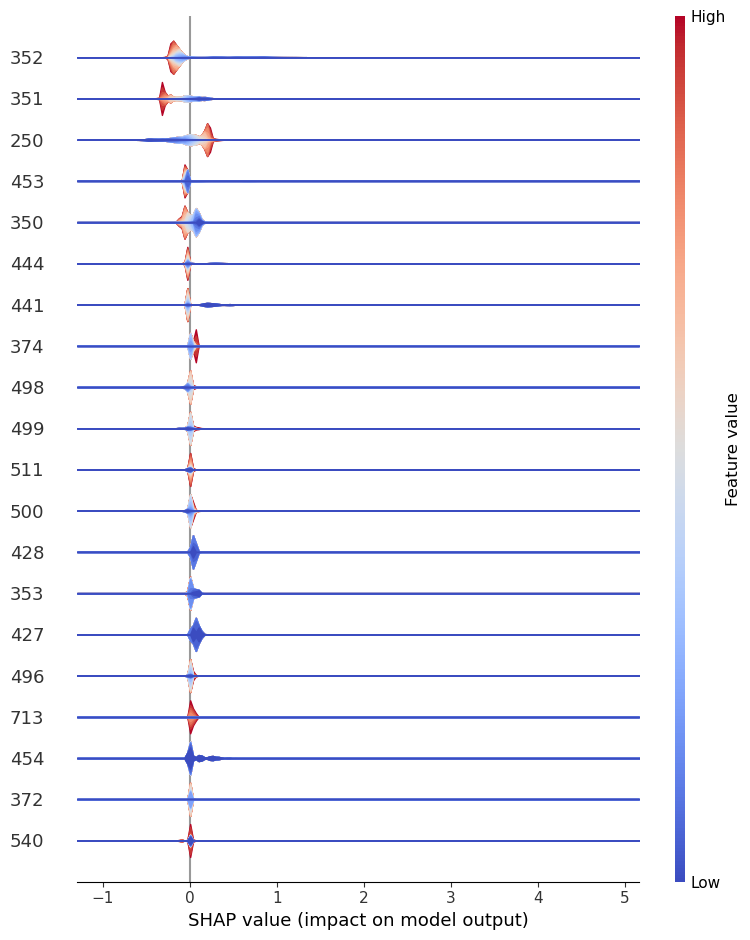

In [57]:
target = 'pha'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs')

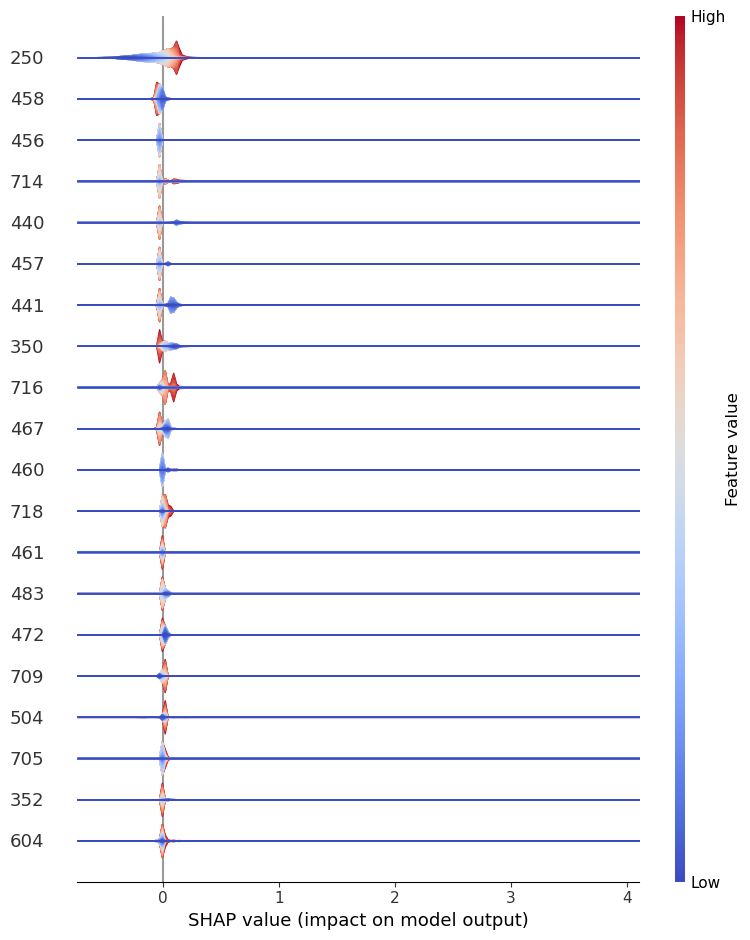

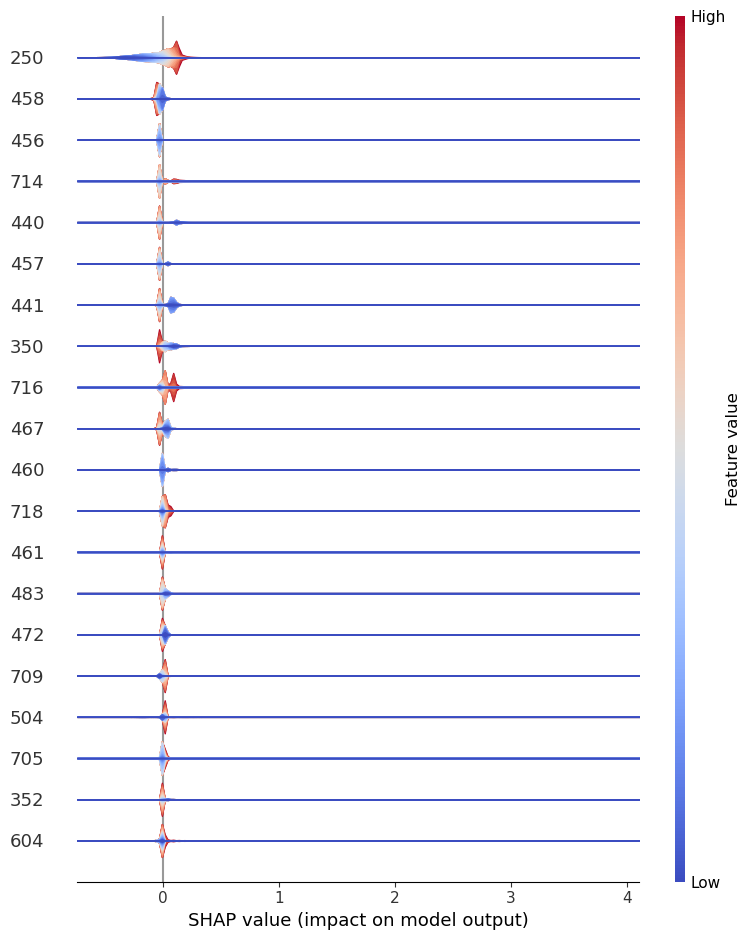

In [58]:
target = 'tot_cphyl'
model_num = model_nums[target]
model = xgbmodel.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test)
plot_shap(shap_values=shap_vals, X=dX_test, target_name=target, input_types='rrs')

---

#### Next is to retrain and predict with a subset of the TOA features.

**Why?**

<br>
$\rightarrow$ There is high correlation between the channels<br>
$\rightarrow$ Could to PCA but might be representative of blue water only<br>
$\rightarrow$ Similar performance to the full-featured set means fitting would be less resource-intensive

**How?**

<br>
$\rightarrow$ Begin by taking every 10 channels. <br>
$\rightarrow$ Keep the same datasset split for a complete comparison of performance



In [61]:
dX_train_sub = dX_train.iloc[:, ::10]
dX_train_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 946205 entries, 2088599 to 76798
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   250     946205 non-null  float64
 1   260     946205 non-null  float64
 2   270     946205 non-null  float64
 3   280     946205 non-null  float64
 4   290     946205 non-null  float64
 5   300     946205 non-null  float64
 6   310     946205 non-null  float64
 7   320     946205 non-null  float64
 8   330     946205 non-null  float64
 9   340     946205 non-null  float64
 10  350     946205 non-null  float64
 11  360     946205 non-null  float64
 12  370     946205 non-null  float64
 13  380     946205 non-null  float64
 14  390     946205 non-null  float64
 15  400     946205 non-null  float64
 16  410     946205 non-null  float64
 17  420     946205 non-null  float64
 18  430     946205 non-null  float64
 19  440     946205 non-null  float64
 20  450     946205 non-null  float64
 21  460     94

In [62]:
dX_test_sub = dX_test.iloc[:,::10]

In [63]:
trainer_sub = XGBoostTrainer(params=params)
xgbmodel_sub = trainer.train_model(dX_train_sub, dY_train_s)

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

In [64]:
Y_pred_sub_s = xgbmodel_sub.predict(dX_test_sub)

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/sklearn/utils/_tags.py:406: DeprecationWarning: The following error was raised: 'super' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or 

In [65]:
Y_pred_sub = scl.inverse_transform(Y_pred_sub_s)

In [66]:
dY_pred_sub = pd.DataFrame(Y_pred_sub, columns=dY_test.columns)

Next is to compute metrics for this, then to experiment with xscaled

In [67]:
eval_scores_sub = model_eval(dY_test, dY_pred_sub)

2025-03-09 10:02:44.806 | INFO     | __main__:model_eval:15 - 
Metrics for dia:
2025-03-09 10:02:44.807 | INFO     | __main__:model_eval:16 -   MSE: 0.0022
2025-03-09 10:02:44.807 | INFO     | __main__:model_eval:17 -   RMSE: 0.0469
2025-03-09 10:02:44.807 | INFO     | __main__:model_eval:18 -   MAE: 0.0279
2025-03-09 10:02:44.808 | INFO     | __main__:model_eval:19 -   R-squared: 0.8635
2025-03-09 10:02:44.808 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.220


2025-03-09 10:02:44.824 | INFO     | __main__:model_eval:15 - 
Metrics for chl:
2025-03-09 10:02:44.825 | INFO     | __main__:model_eval:16 -   MSE: 0.0007
2025-03-09 10:02:44.826 | INFO     | __main__:model_eval:17 -   RMSE: 0.0260
2025-03-09 10:02:44.826 | INFO     | __main__:model_eval:18 -   MAE: 0.0142
2025-03-09 10:02:44.826 | INFO     | __main__:model_eval:19 -   R-squared: 0.7174
2025-03-09 10:02:44.826 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.289
2025-03-09 10:02:44.838 | INFO     | __main__:model_eval:15 - 
Metrics for cya:
2025-03-09 10:02:44.839 | INFO     | __main__:model_eval:16 -   MSE: 0.0000
2025-03-09 10:02:44.839 | INFO     | __main__:model_eval:17 -   RMSE: 0.0050
2025-03-09 10:02:44.839 | INFO     | __main__:model_eval:18 -   MAE: 0.0028
2025-03-09 10:02:44.839 | INFO     | __main__:model_eval:19 -   R-squared: 0.9628
2025-03-09 10:02:44.840 | INFO     | __main__:model_eval:20 -   MAE/StDev_true 0.110
2025-03-09 10:02:44.848 | INFO     | __main__:mo

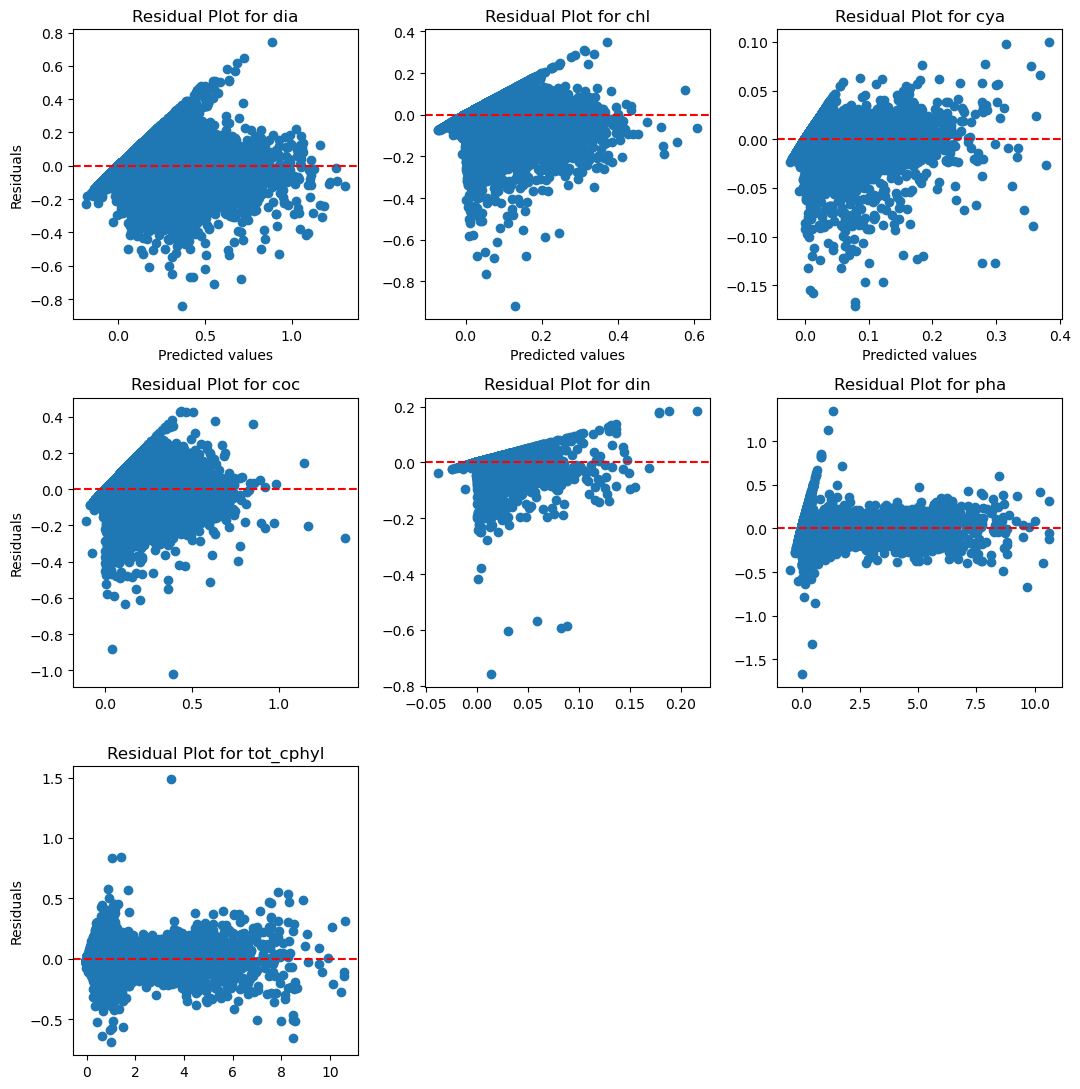

In [68]:
f, axs = pp.subplots(nrows=3, ncols=3, figsize=(11, 11))
for ax, col in zip(axs.ravel(), dY_test.columns):
    try:
        plot_residuals(dY_test[col].values, dY_pred_sub[col].values, ax, col)
    except:
        logger.error(f"problem with {col}")
    ss = ax.get_subplotspec()
    if not ss.is_first_col:
        ax.set_ylabel("")
    if not ss.is_first_row:
        ax.set_xlabel("")
for ax in axs.flat[-2:]:
    ax.set_visible(False)
f.tight_layout()   

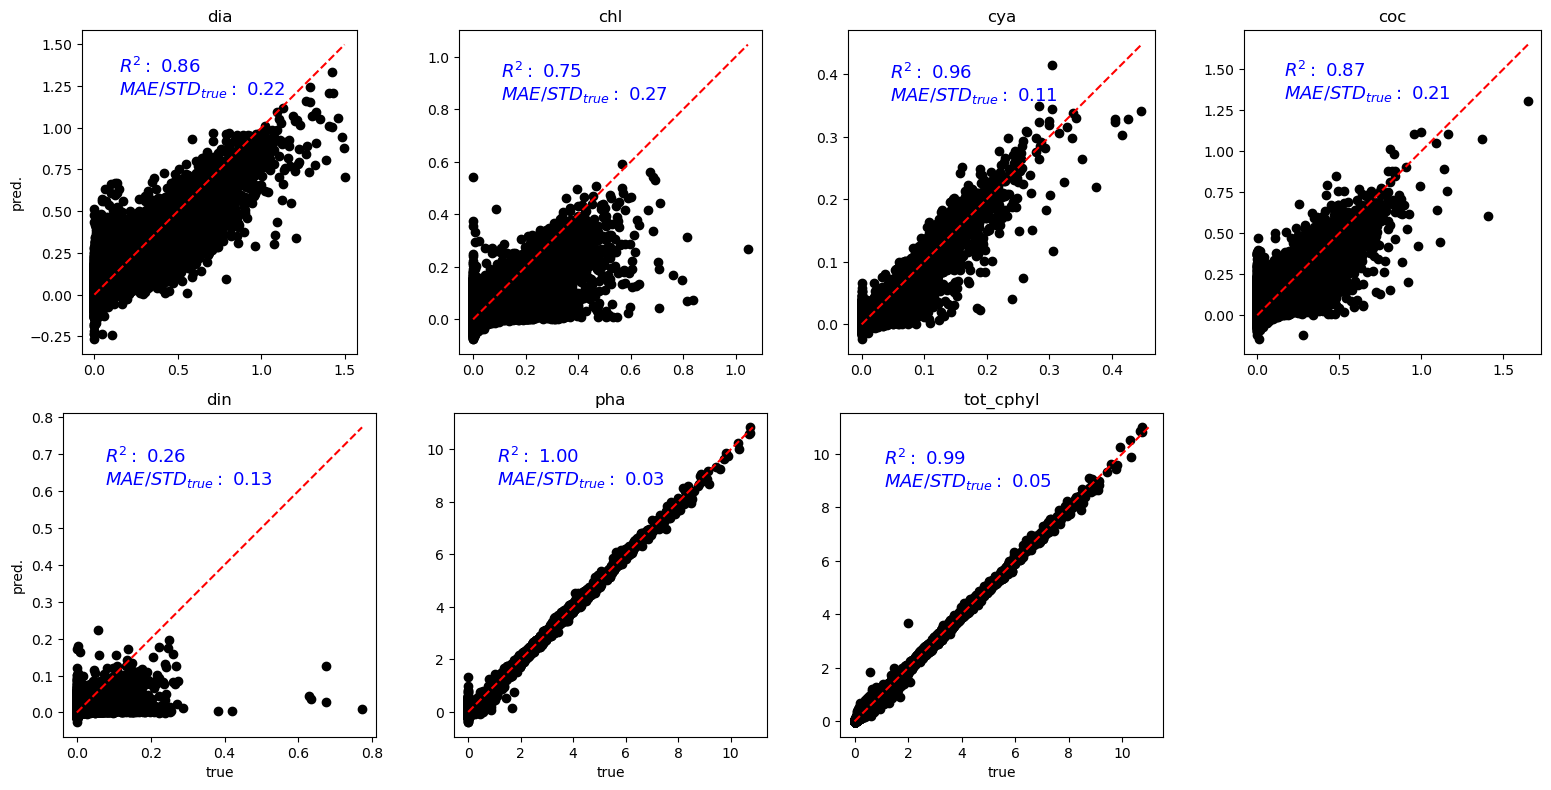

In [69]:
fsub, axs = pp.subplots(nrows=2, ncols=4, figsize=(16, 8))
for col, ax in zip(dY_test.columns, axs.ravel()):
    r2 = eval_scores[col]['r2']
    mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
    string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
    plot_regression(dY_test[col], dY_pred[col], col, ax=ax, leg=string)
for ax in axs.ravel()[-1:]:
    ax.set_visible(False)
fsub.tight_layout()
fsub.savefig('true_v_pred_sub.pdf', dpi=300)
fsub.savefig('true_v_pred_sub.png', dpi=300)

$→$ Performance has not degraded as aa result of removing 90% of the input data.

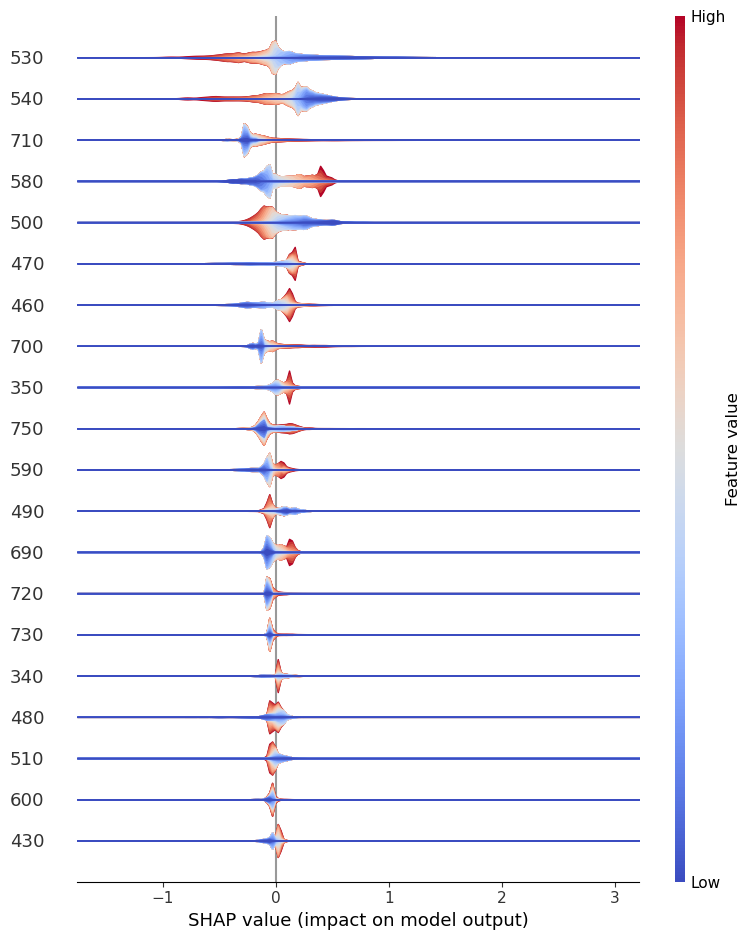

In [84]:
target = 'dia'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_dia = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

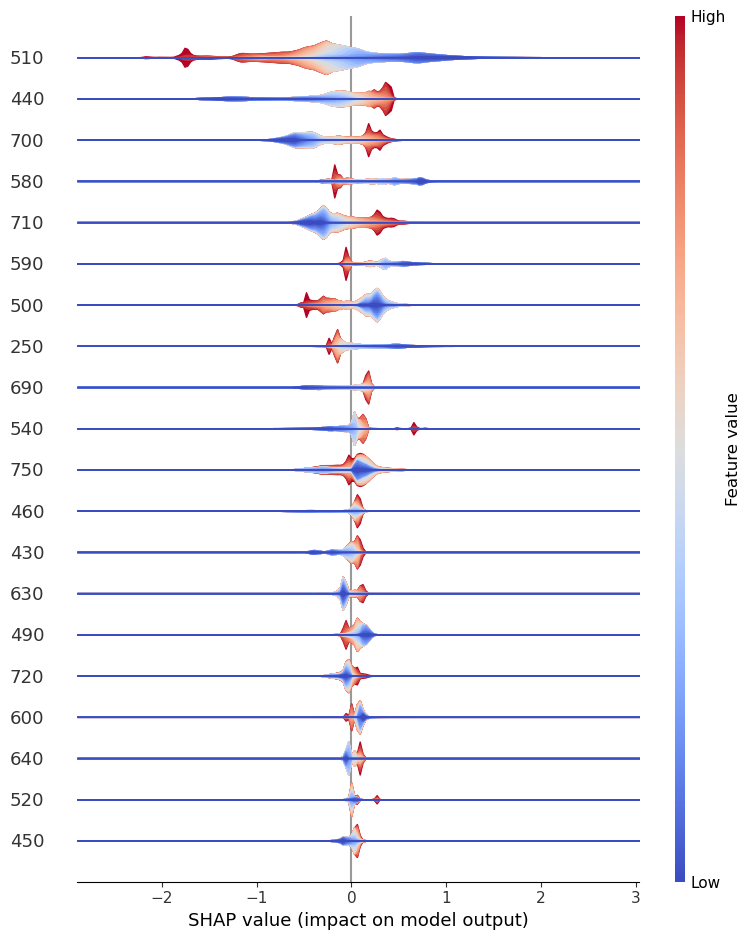

In [85]:
target = 'chl'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_chl = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

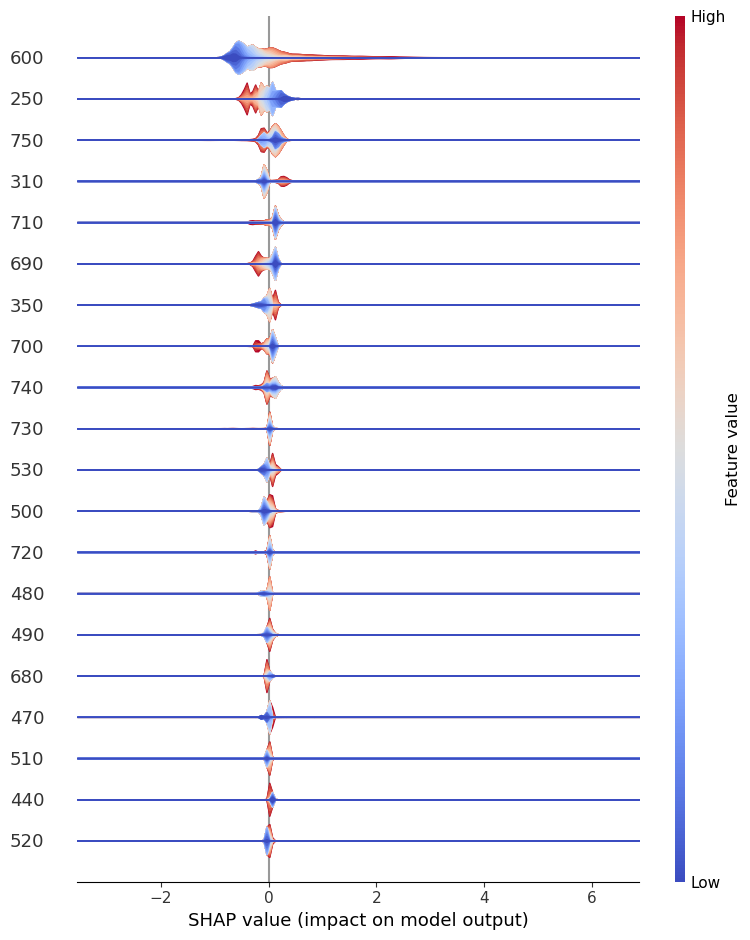

In [86]:
target = 'cya'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_cya = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

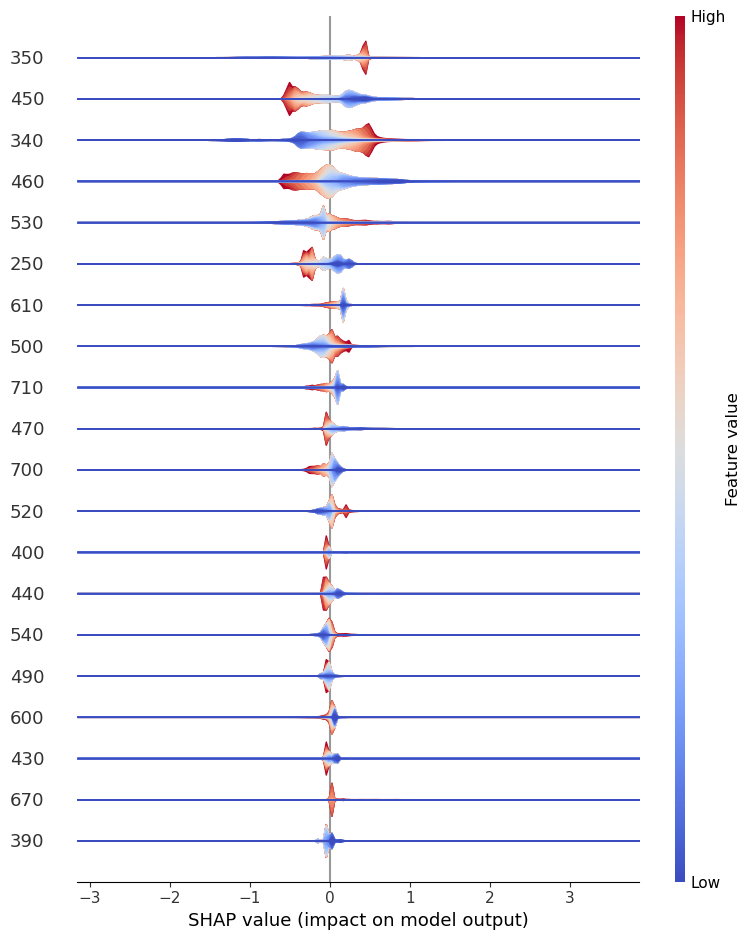

In [87]:
target = 'coc'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_coc = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

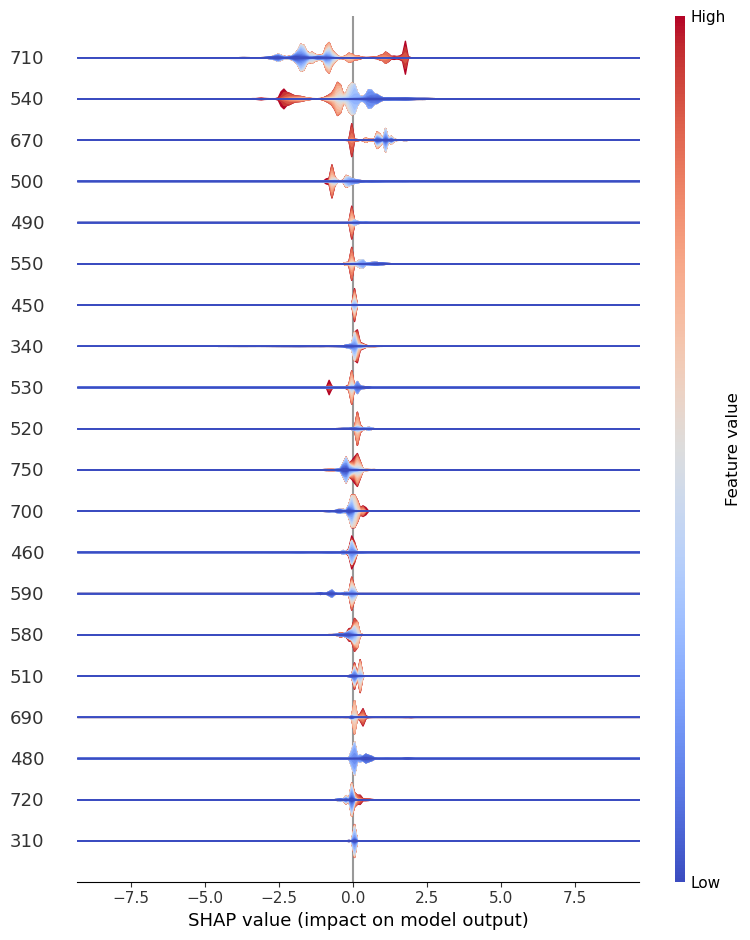

In [88]:
target = 'din'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_din = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

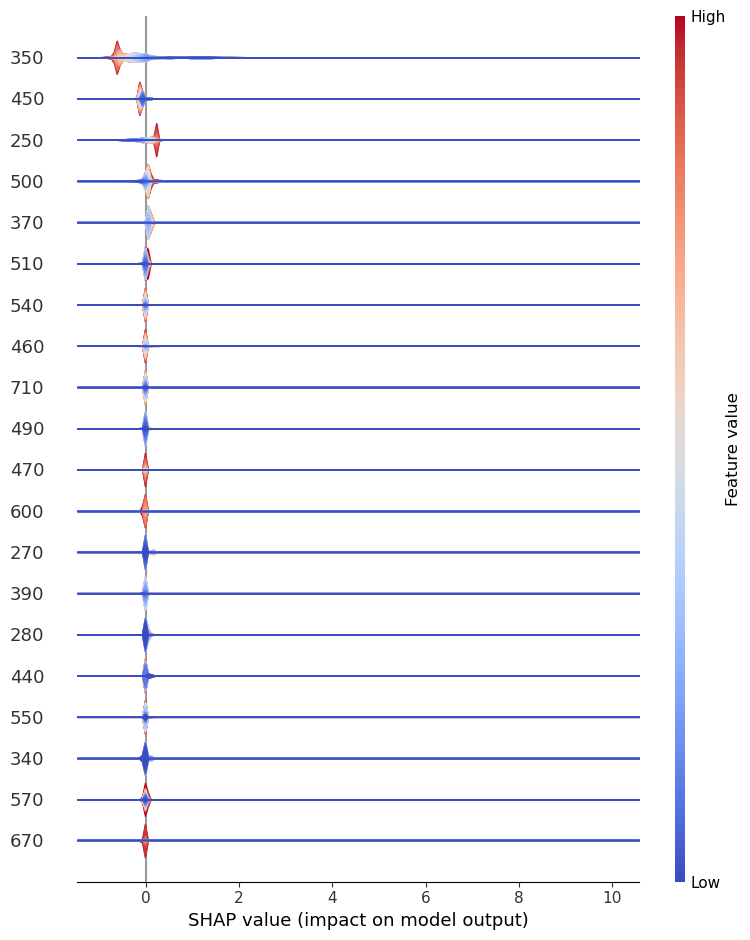

In [89]:
target = 'pha'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_pha = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

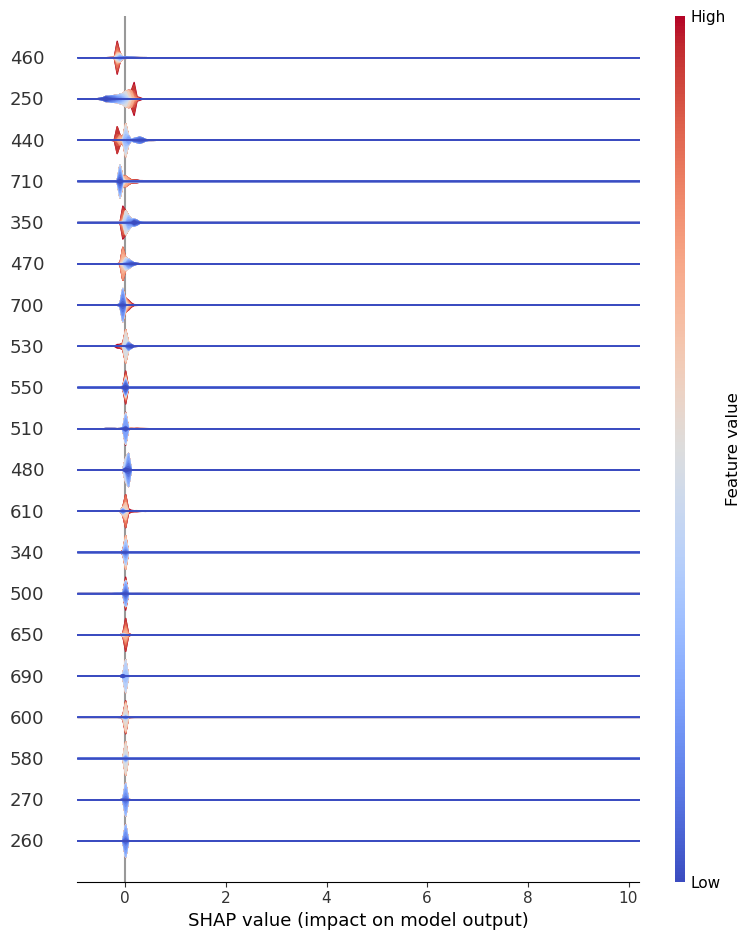

In [90]:
target = 'tot_cphyl'
model_num = model_nums[target]
model = xgbmodel_sub.estimators_[model_num]
shap_vals = compute_shapley_values(model=model, X=dX_test_sub)
main_features_tot_cphyl = get_main_features(shap_vals, dX_test_sub)
plot_shap(shap_values=shap_vals, X=dX_test_sub, target_name=target, input_types='rrs')

The below represents the most important features for each model prediction

In [102]:
main_feature_df = pd.DataFrame(
    {'dia': main_features_dia[:20],
     'chl': main_features_chl[:20],
     'cya': main_features_cya[:20],
     'coc': main_features_coc[:20],
     'din': main_features_din[:20],
     'pha': main_features_pha[:20],
     'tot_chphyl': main_features_tot_cphyl[:20]
        }
    )
main_feature_df['Importance'] = main_feature_df.index
main_feature_df.set_index('Importance', inplace=True)
main_feature_df

,dia,chl,cya,coc,din,pha,tot_chphyl
Importance,,,,,,,
0,530,510,600,350,710,350,460
1,540,440,250,450,540,450,250
2,710,700,750,340,670,250,440
3,580,580,310,460,500,500,710
4,500,710,710,530,490,370,350
5,470,590,690,250,550,510,470
6,460,500,350,610,450,540,700
7,700,250,700,500,340,460,530
8,350,690,740,710,530,710,550


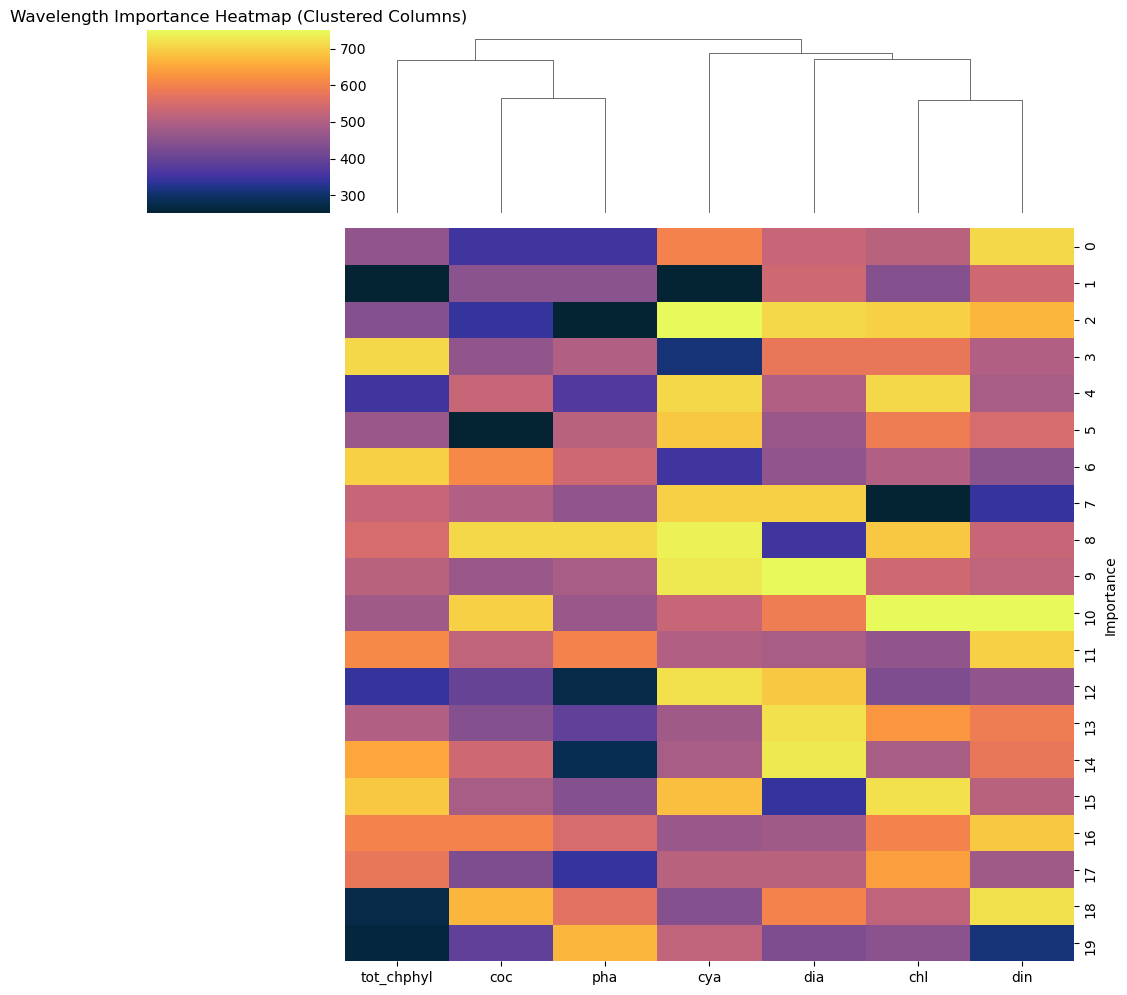

In [ ]:
sb.clustermap(
    main_feature_df, cmap=co.cm.thermal, row_cluster=False, annot=False,
    )  #row_cluster=False, because rows are already in order of importance.
pp.title('Wavelength Importance Heatmap (Clustered Columns)')


In [ ]:
fig = px.parallel_coordinates(
    main_feature_df.reset_index(), color='Importance', labels=dict(Importance="Importance Rank"),  
    )
fig.show()

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

